source link : https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset

# **Phase-1**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from sklearn.metrics import roc_curve, auc, silhouette_score, calinski_harabasz_score, confusion_matrix, davies_bouldin_score, r2_score, mean_squared_error,accuracy_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import fcluster

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Loading the dataset
df = pd.read_excel(r"C:\Users\L E N O V O\Desktop\DIC\vignesht_amulyare_manasala_phase1\src\Online Retail.xlsx")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [5]:
print('Original Shape:',df.shape)

Original Shape: (541909, 8)


In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [8]:
#remove duplicates
df.drop_duplicates(inplace=True)

This step eliminated duplicate entries from the dataset. Duplicate records can skew analysis results and lead to over representation of certain data points. Rremoving of these duplicates ensured that each transaction or entry is unique.

In [9]:
#remove missing values
df.dropna(inplace=True)

This step removed rows containing any missing values from the dataset. By eliminating incomplete records, we ensured data consistency and prevented potential errors in subsequent analysis.

In [10]:
#Data type conversion
df['CustomerID'] = df['CustomerID'].astype(int)

In this step, we converted the ’CustomerID’ column from its original data type to integer format. This conversion ensures that customer identifiers are stored and processed as numerical values, facilitating efficient indexing, sort-ing, and analysis of customer related data.

In [11]:
#Standardizing Date Formats
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In this step, we converted the ’InvoiceDate’ column to a consistent datetime format. This standardization ensures all date values are in a uniform format, facilitating accurate time-based analysis, sorting, and filtering. It also helps prevent errors that can arise from inconsistent date representations across the dataset.

In [12]:
#feature engineering
df['Total_Price'] = df['Quantity'] * df['UnitPrice']
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
df['Season'] = df['Month'].apply(get_season)

In this step, we created new features to enrich our dataset and enable more comprehensive analysis. We calculated the total transaction amount, extracted temporal 
components (year, month, day of week) from the invoice date, and derived a seasonal attribute. These new features provide additional dimensions for customer segmentation, allowing for deeper insights into purchasing patterns, temporal trends, and seasonal behaviors.

In [13]:
#Removing invalid data
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

This step involved filtering out records with non-positive quantities or unit prices. By retaining only transactions with valid, positive values for these key attributes, we
ensured the dataset reflects genuine sales activities. This cleaning process helps in subsequent analysis, particularly in calculations involving financial metrics or product
volumes.

In [14]:
#Removing whitespaces in strings
def safe_strip(x):
    return x.strip() if isinstance(x, str) else x
str_col = df.select_dtypes(include=['object']).columns
df[str_col] = df[str_col].applymap(safe_strip)

In [15]:
#removing special characters in strings
def clean_txt(text):
    return re.sub(r'[^\w\s]', '', str(text))
txt_col = df.select_dtypes(include=['object']).columns
for column in txt_col:
    try:
        df[column] = df[column].apply(clean_txt)
    except KeyError:
        print(f"Column '{column}' not found in the DataFrame. Skipping.")

In [16]:
#Handling Inconsistent Capitalization
def product_categorize(description):
    if 'GIFT' in description.upper():
        return 'Gift'
    elif 'SET' in description.upper():
        return 'Set'
    else:
        return 'Regular'
df['ProductCategory'] = df['Description'].apply(product_categorize)

In this data cleaning process, we standardized text data across all string-type columns by removing leading and trailing whitespaces, eliminating special characters, and
retaining only alphanumeric characters and spaces. We also addressed inconsistent capitalization by converting product descriptions to uppercase and categorizing them
based on standardized keywords.

In [17]:
#Removing outliers
Q1 = df['Total_Price'].quantile(0.25)
Q3 = df['Total_Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Total_Price'] >= Q1 - 1.5 * IQR) & (df['Total_Price'] <= Q3 + 1.5 * IQR)]

This step identified and removed extreme values in the ’TotalAmount’ column using the Interquartile Range (IQR) method. By eliminating data points that fell outside
1.5 times the IQR below the first quartile or above the third quartile, we reduced the impact of outliers on our analysis. This process helped ensure that our dataset
more accurately represented typical customer behavior and transaction patterns.

In [18]:
#Removing Non-Product Entries
def valid_product(desc):
    invalid_desc = ['damaged', 'sample', 'postage', 'lost', 'found', 'check', 'adjustment']
    return not any(pattern in desc.lower() for pattern in invalid_desc)
df = df[df['Description'].apply(valid_product)]

This data cleaning step filters out non-product entries from the dataset. It removes rows where the ’Description’ contains words typically associated with administrative tasks, damaged goods, or non-sale items (such as ’damaged’, ’sample’, ’postage’, ’lost’, ’found’, ’check’, ’adjustment’). By applying this filter, the dataset is refined
to include only entries that likely represent actual product sales, improving the quality and relevance of the data for subsequent analysis of retail transactions.

In [19]:
# Handling misplaced decimals in unitprice
avg_prices = df.groupby('StockCode')['UnitPrice'].median()
def correct_decimal(price, avg_price):
    if pd.notnull(price) and pd.notnull(avg_price):
        if price > 100 * avg_price:
            return price / 100
        elif price < avg_price / 100:
            return price * 100
    return price
df['UnitPrice'] = df.apply(lambda row: correct_decimal(row['UnitPrice'], avg_prices.get(row['StockCode'], np.nan)), axis=1)

This step corrects inaccuracies in the ’UnitPrice’ column by identifying and adjusting misplaced decimal points. By comparing each price to the median price for its
corresponding StockCode, it ensures that unit prices are standardized and accurately reflect true values, thereby enhancing overall data quality for analysis.

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Year,Month,DayOfWeek,Season,ProductCategory
0,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,2,Winter,Regular
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,Winter,Regular
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,2,Winter,Regular
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,Winter,Regular
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,Winter,Regular


In [21]:
#Categorizing customers
def categorize_customer(total_price):
    if total_price < 100:
        return 'Low'
    elif total_price < 1000:
        return 'Medium'
    else:
        return 'High'
customer_totals = df.groupby('CustomerID')['Total_Price'].sum()
df['CustomerSegment'] = df['CustomerID'].map(customer_totals).apply(categorize_customer)

In [22]:
#categorizing purchance frequency
purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
df['PurchaseFrequency'] = df['CustomerID'].map(purchase_frequency)

In [23]:
#Creating Recency , Frequency and Monetary values row
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Get the most recent date in the dataset
max_date = df['InvoiceDate'].max()
# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'Total_Price': 'sum'  # Monetary
})
# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
# Create R, F, and M quartiles
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)
# Add quartile columns to RFM dataframe
rfm['R'] = r_quartiles
rfm['F'] = f_quartiles
rfm['M'] = m_quartiles
# Calculate RFM Score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
# Create RFM Segment
def rfm_segment(row):
    if row['RFM_Score'] in ['444', '434', '443', '433']:
        return 'Best Customers'
    elif row['RFM_Score'] in ['441', '442', '432', '423', '424']:
        return 'Loyal Customers'
    elif row['RFM_Score'] in ['311', '422', '421', '412', '411']:
        return 'Lost Customers'
    elif row['RFM_Score'] in ['211', '212', '221']:
        return 'Lost Cheap Customers'
    else:
        return 'Other'
rfm['RFM_Segment'] = rfm.apply(rfm_segment, axis=1)
# Merge RFM features back to the original dataframe
df = df.merge(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'RFM_Segment']], 
              on='CustomerID', 
              how='left')
print(df[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'RFM_Segment']].head())

   CustomerID  Recency  Frequency  Monetary RFM_Score RFM_Segment
0       17850      371        288   4732.46       144       Other
1       17850      371        288   4732.46       144       Other
2       17850      371        288   4732.46       144       Other
3       17850      371        288   4732.46       144       Other
4       17850      371        288   4732.46       144       Other


In [24]:
print('Shape of data frame after data cleaning and processing',df.shape)

Shape of data frame after data cleaning and processing (360763, 21)


In [25]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Year,Month,DayOfWeek,Season,ProductCategory,CustomerSegment,PurchaseFrequency,Recency,Frequency,Monetary,RFM_Score,RFM_Segment
0,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,2,Winter,Regular,High,34,371,288,4732.46,144,Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,Winter,Regular,High,34,371,288,4732.46,144,Other
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,2,Winter,Regular,High,34,371,288,4732.46,144,Other
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,Winter,Regular,High,34,371,288,4732.46,144,Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,Winter,Regular,High,34,371,288,4732.46,144,Other


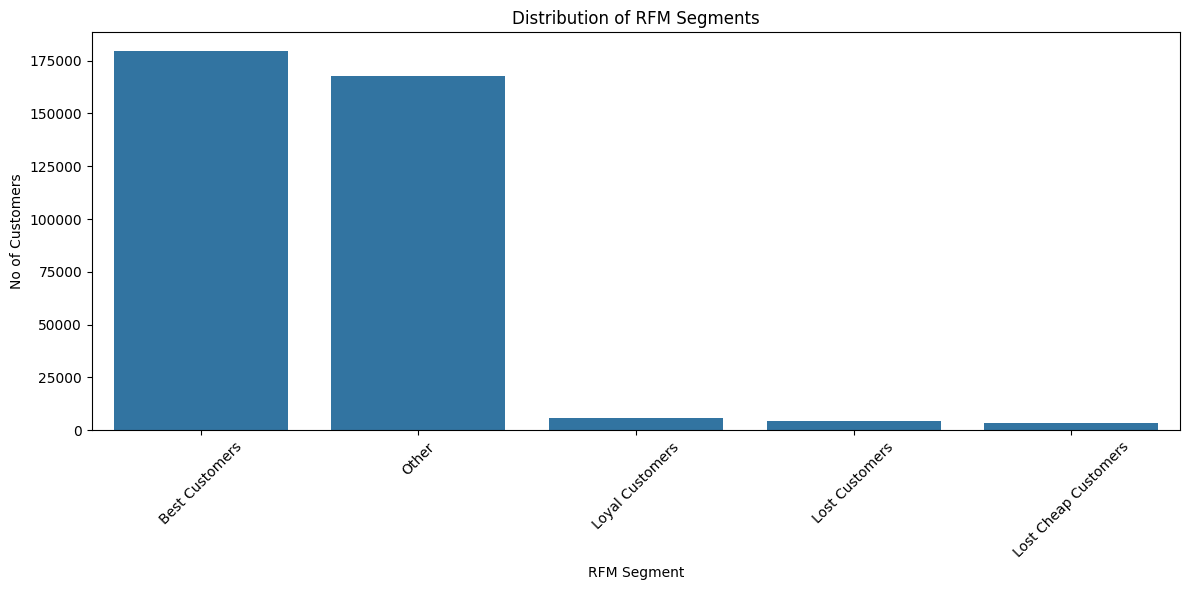

In [26]:
plt.figure(figsize=(12, 6))
segment_counts = df['RFM_Segment'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Distribution of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('No of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

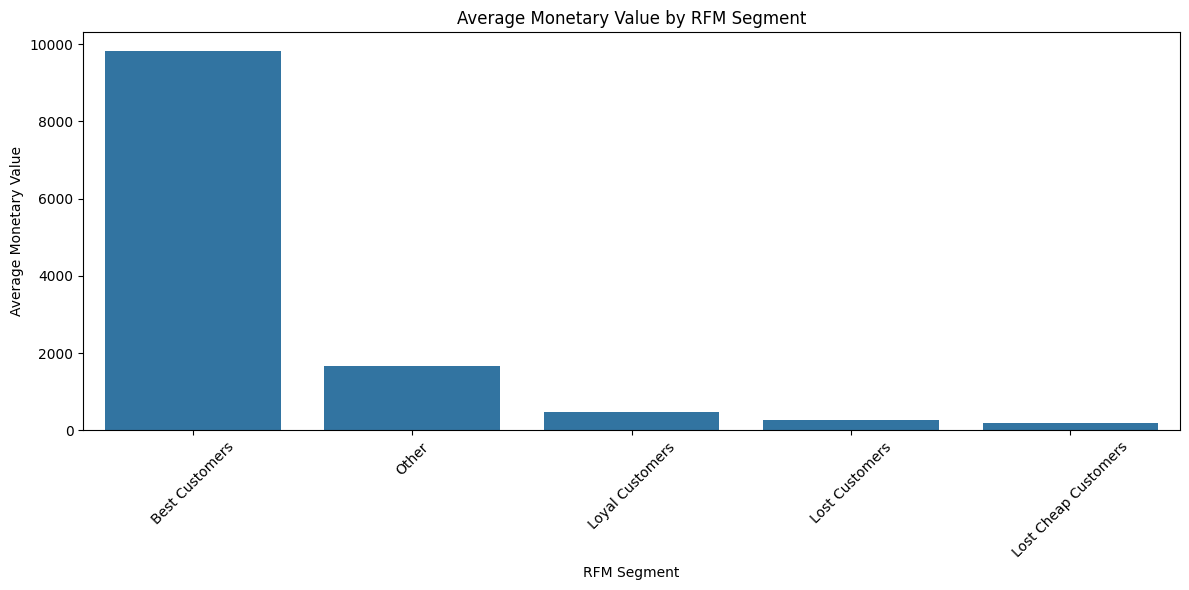

In [27]:
plt.figure(figsize=(12, 6))
segment_monetary = df.groupby('RFM_Segment')['Monetary'].mean().sort_values(ascending=False)
sns.barplot(x=segment_monetary.index, y=segment_monetary.values)
plt.title('Average Monetary Value by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

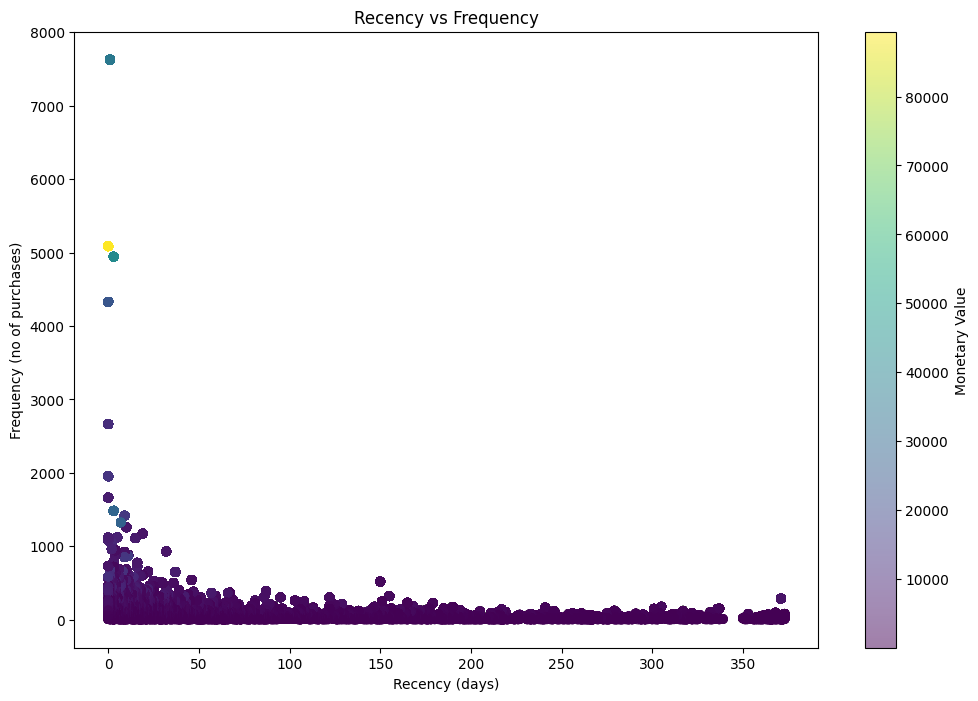

In [28]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Recency'], df['Frequency'], c=df['Monetary'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Monetary Value')
plt.title('Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (no of purchases)')
plt.show()

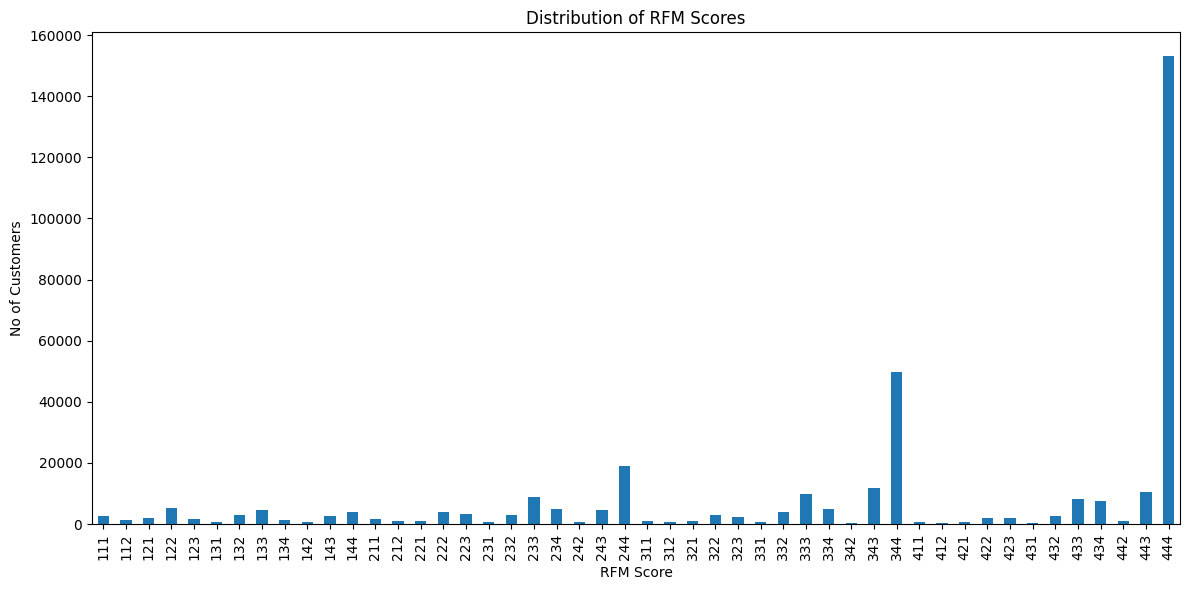

In [29]:
plt.figure(figsize=(12, 6))
df['RFM_Score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('No of Customers')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

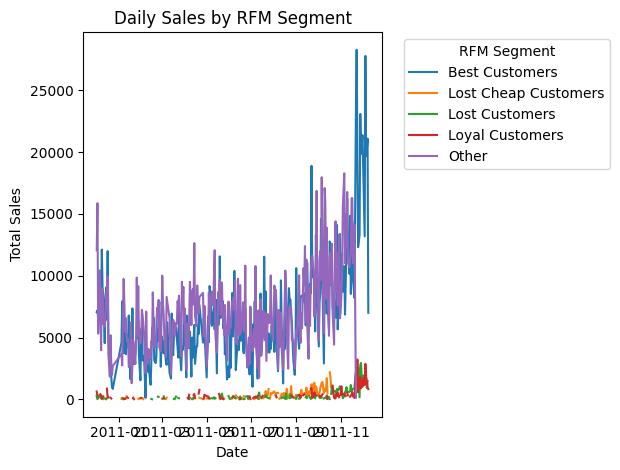

In [30]:
df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
segment_sales = df.groupby(['Date', 'RFM_Segment'])['Total_Price'].sum().unstack()
plt.figure(figsize=(14, 8))
segment_sales.plot(kind='line')
plt.title('Daily Sales by RFM Segment')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

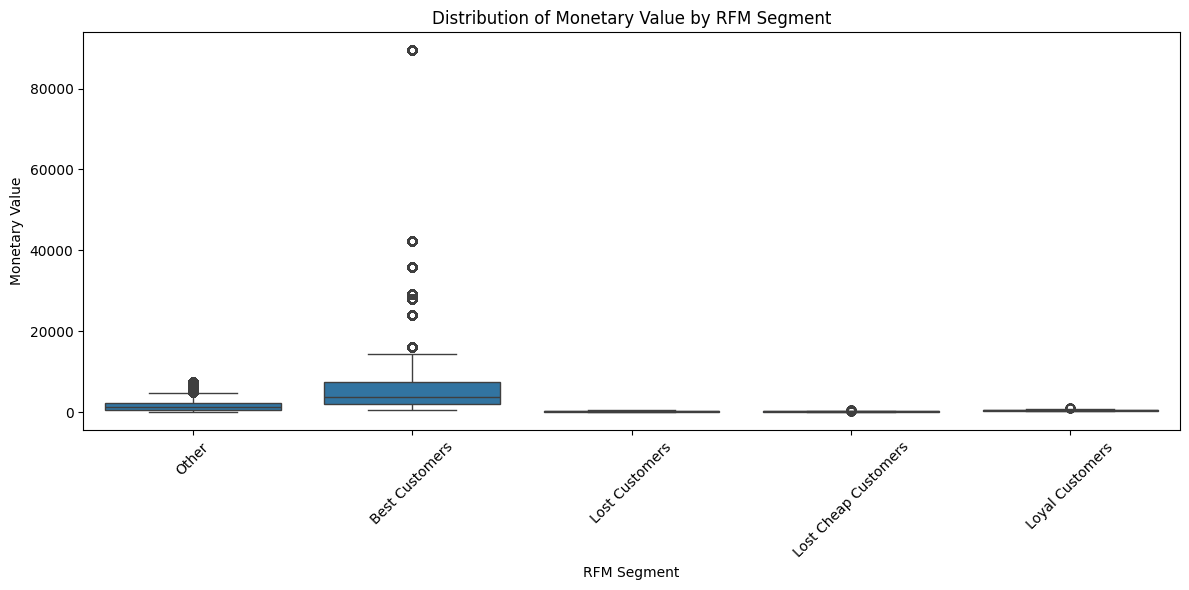

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='RFM_Segment', y='Monetary', data=df)
plt.title('Distribution of Monetary Value by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Monetary Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

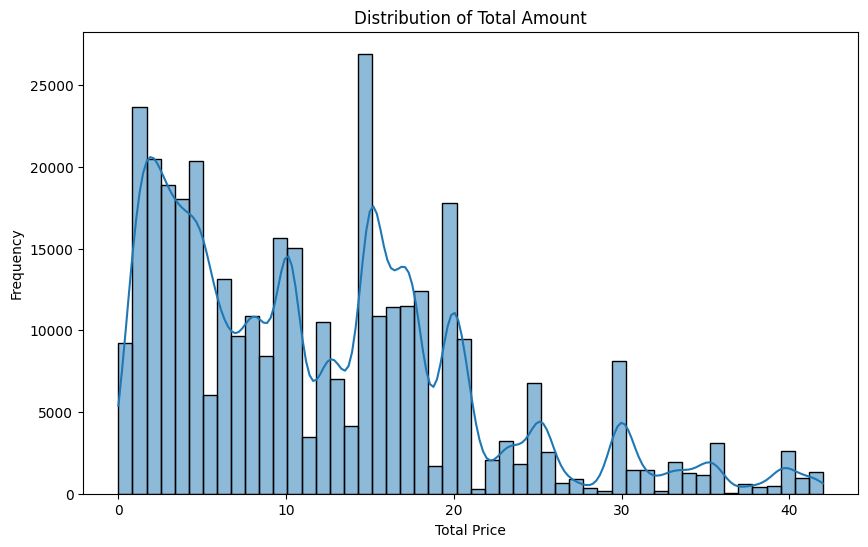

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Price'], kde=True, bins=50)
plt.title('Distribution of Total Amount')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()

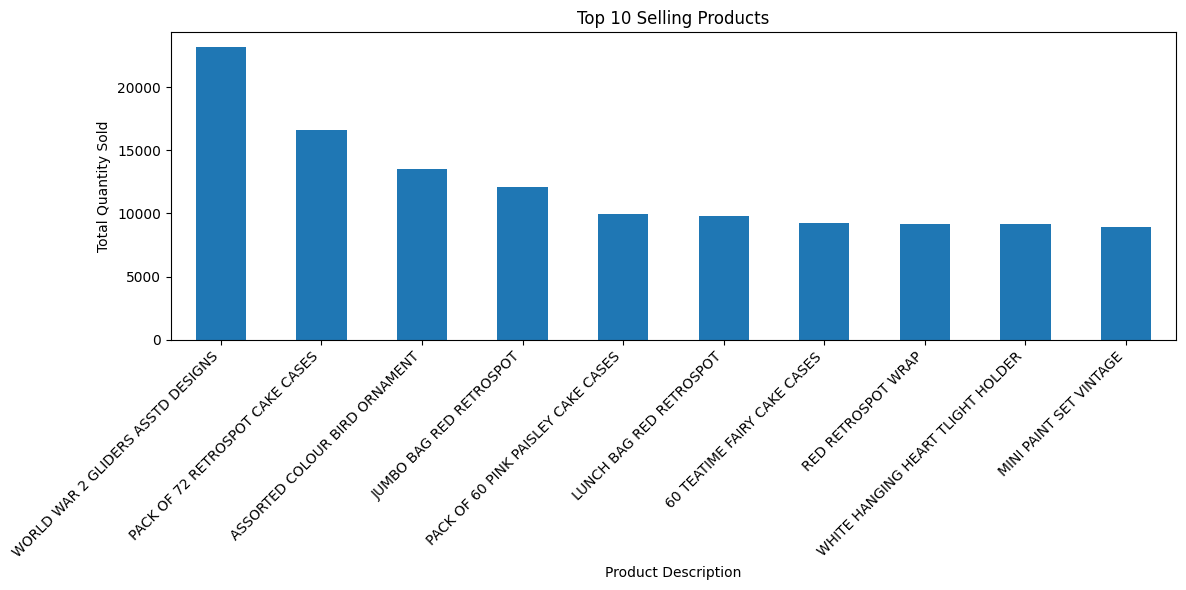

In [33]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Selling Products')
plt.xlabel('Product Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

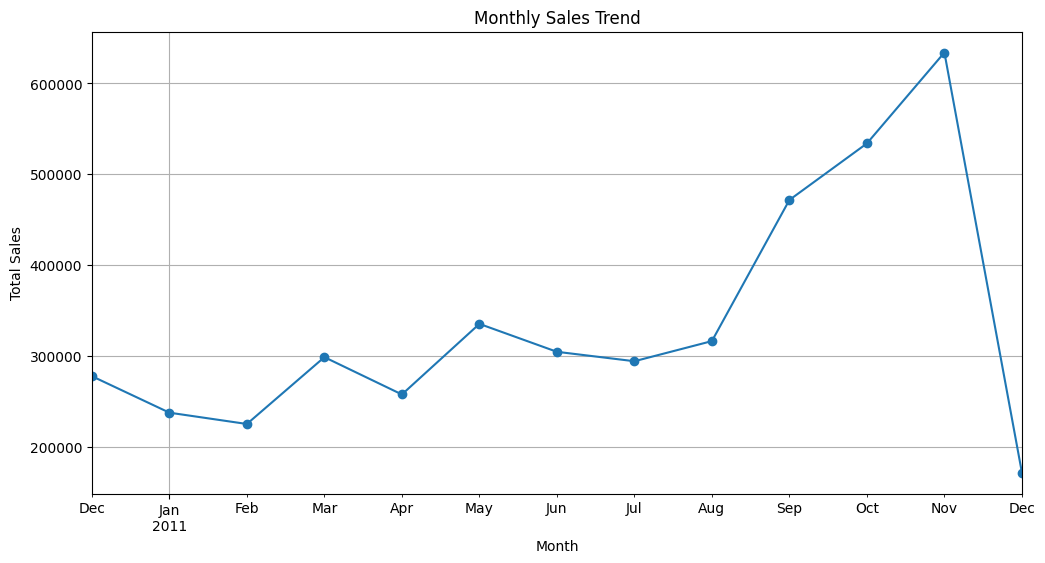

In [34]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Total_Price'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

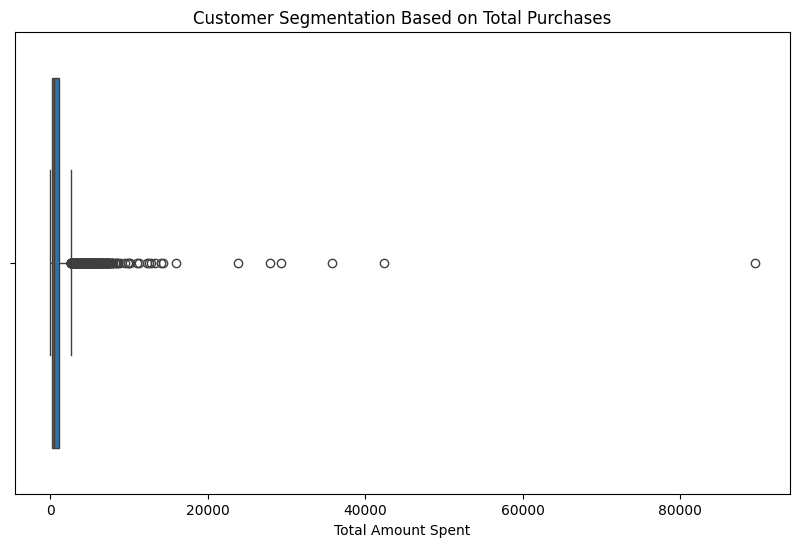

In [35]:
customer_segments = df.groupby('CustomerID')['Total_Price'].sum()
plt.figure(figsize=(10, 6))
sns.boxplot(x=customer_segments)
plt.title('Customer Segmentation Based on Total Purchases')
plt.xlabel('Total Amount Spent')
plt.show()

           InvoiceNo       Quantity      UnitPrice     CustomerID  \
count  360763.000000  360763.000000  360763.000000  360763.000000   
mean   560683.683216       7.905703       2.724554   15317.528255   
std     13092.884488      10.300789       2.786293    1707.432173   
min    536365.000000       1.000000       0.001000   12347.000000   
25%    549274.000000       2.000000       1.250000   13992.000000   
50%    561917.000000       4.000000       1.690000   15211.000000   
75%    572129.000000      12.000000       3.290000   16813.000000   
max    581587.000000     900.000000      40.460000   18287.000000   

         Total_Price           Year      DayOfWeek  PurchaseFrequency  \
count  360763.000000  360763.000000  360763.000000      360763.000000   
mean       12.077547    2010.935315       2.628748          17.509856   
std         9.080398       0.245970       1.943545          36.097324   
min         0.001000    2010.000000       0.000000           1.000000   
25%         4

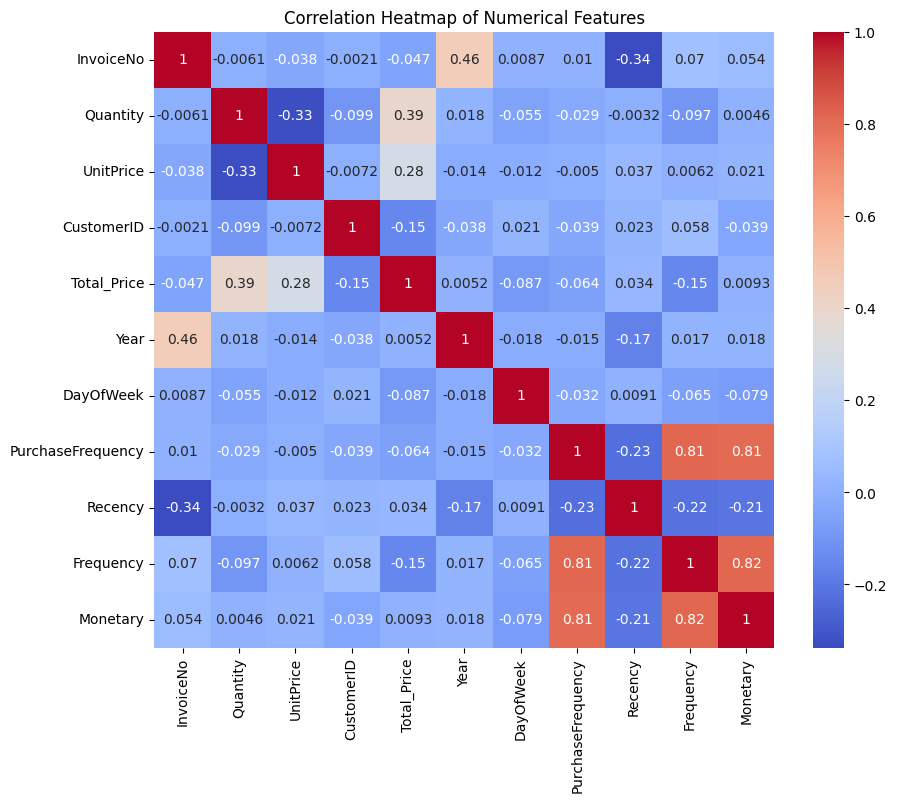

In [36]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(df[numeric_columns].describe())
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

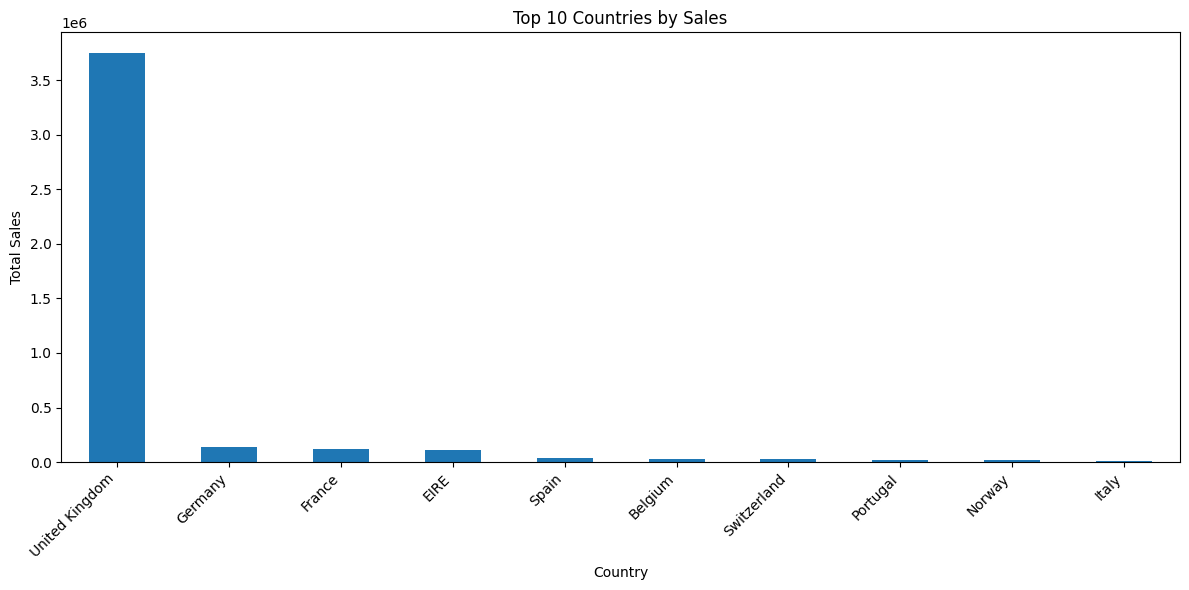

In [37]:
country_sales = df.groupby('Country')['Total_Price'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
country_sales.plot(kind='bar')
plt.title('Top 10 Countries by Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

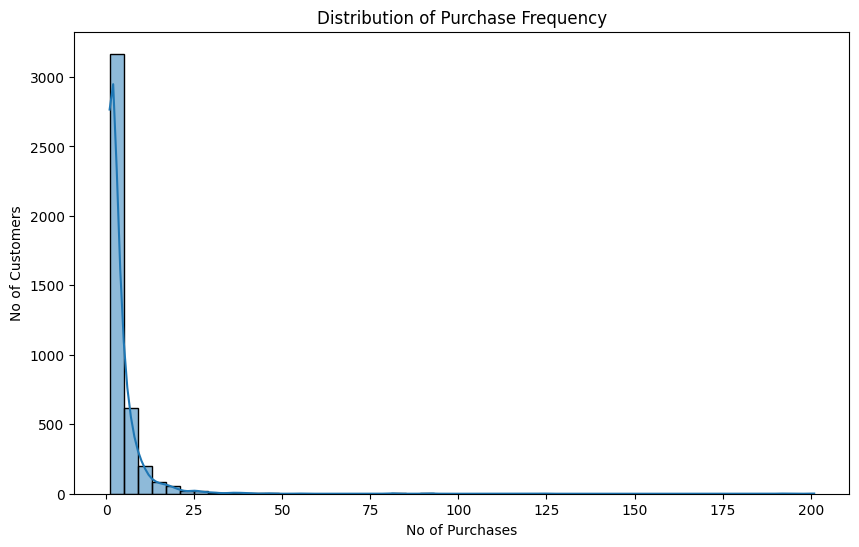

In [38]:
purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
plt.figure(figsize=(10, 6))
sns.histplot(purchase_frequency, kde=True, bins=50)
plt.title('Distribution of Purchase Frequency')
plt.xlabel('No of Purchases')
plt.ylabel('No of Customers')
plt.show()

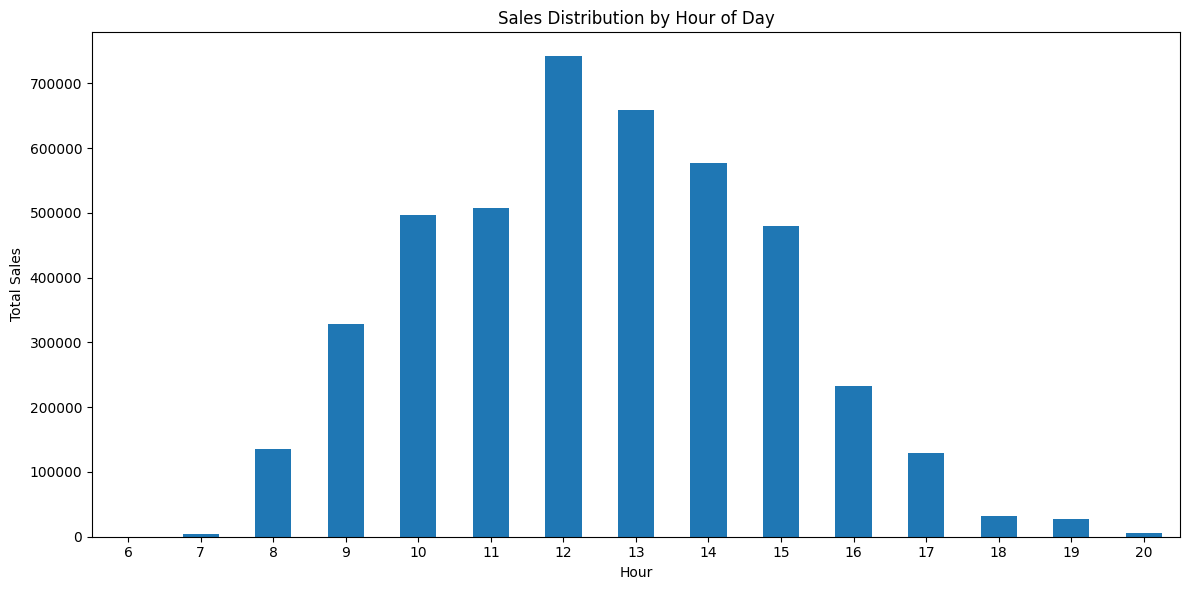

In [39]:
df['Hour'] = df['InvoiceDate'].dt.hour
hourly_sales = df.groupby('Hour')['Total_Price'].sum()
plt.figure(figsize=(12, 6))
hourly_sales.plot(kind='bar')
plt.title('Sales Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

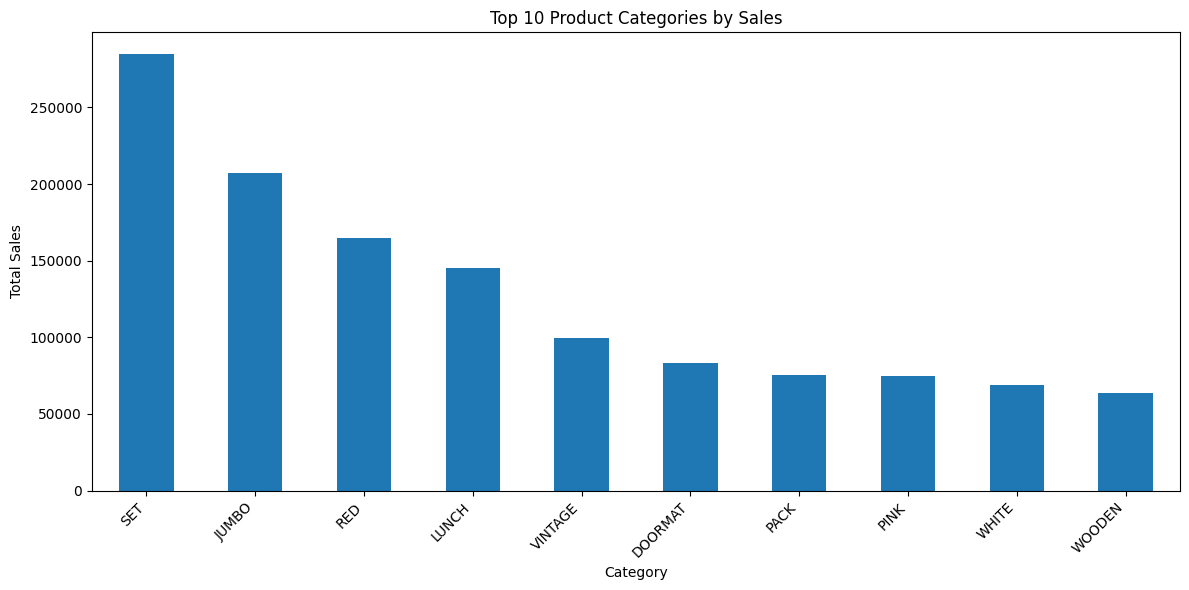

In [40]:
df['Category'] = df['Description'].apply(lambda x: x.split()[0])
category_sales = df.groupby('Category')['Total_Price'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
category_sales.plot(kind='bar')
plt.title('Top 10 Product Categories by Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

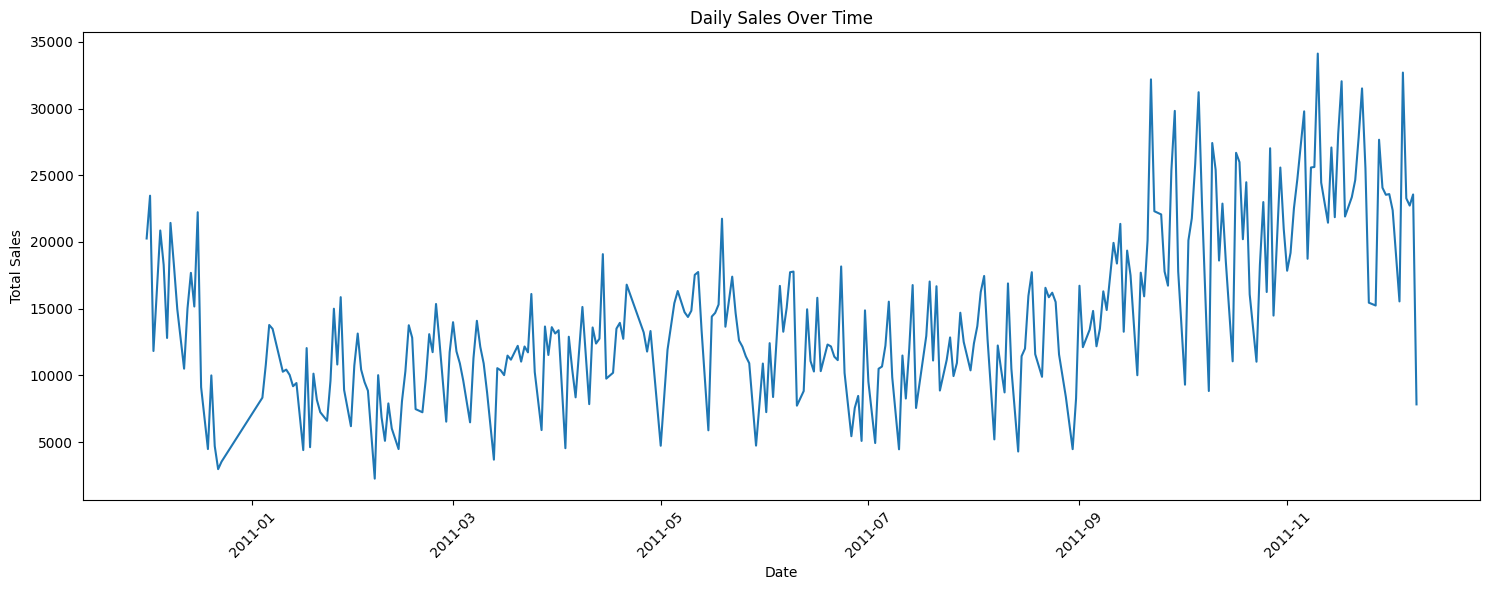

In [41]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Total_Price'].sum().reset_index()
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['InvoiceDate'], daily_sales['Total_Price'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

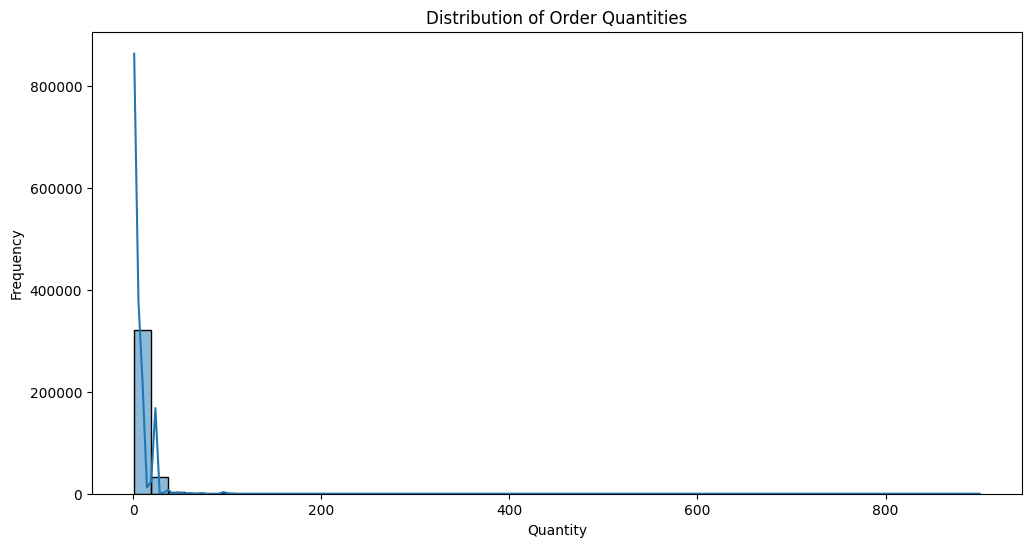

In [42]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title('Distribution of Order Quantities')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

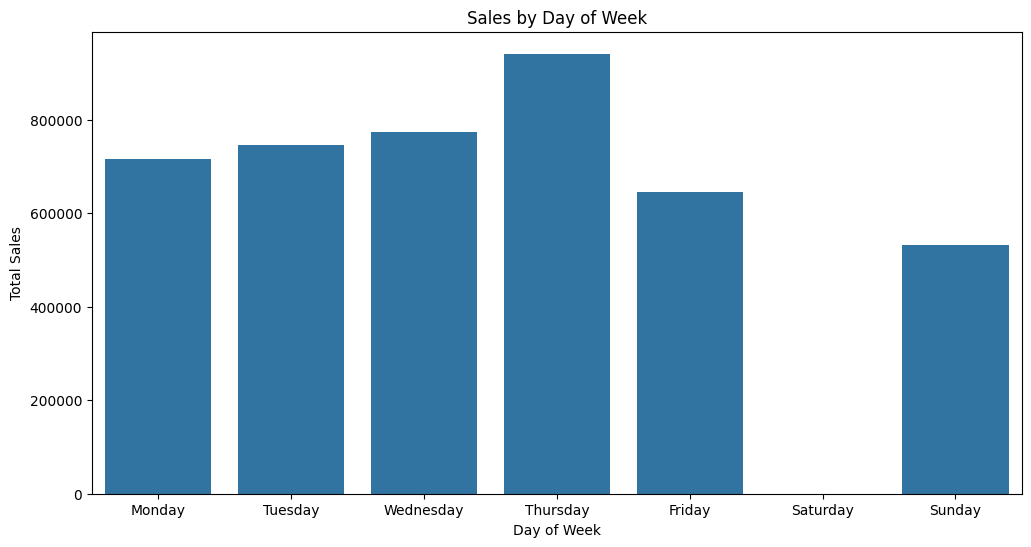

In [43]:
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
day_sales = df.groupby('DayOfWeek')['Total_Price'].sum().reindex(range(7))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.barplot(x=day_names, y=day_sales.values)
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.show()

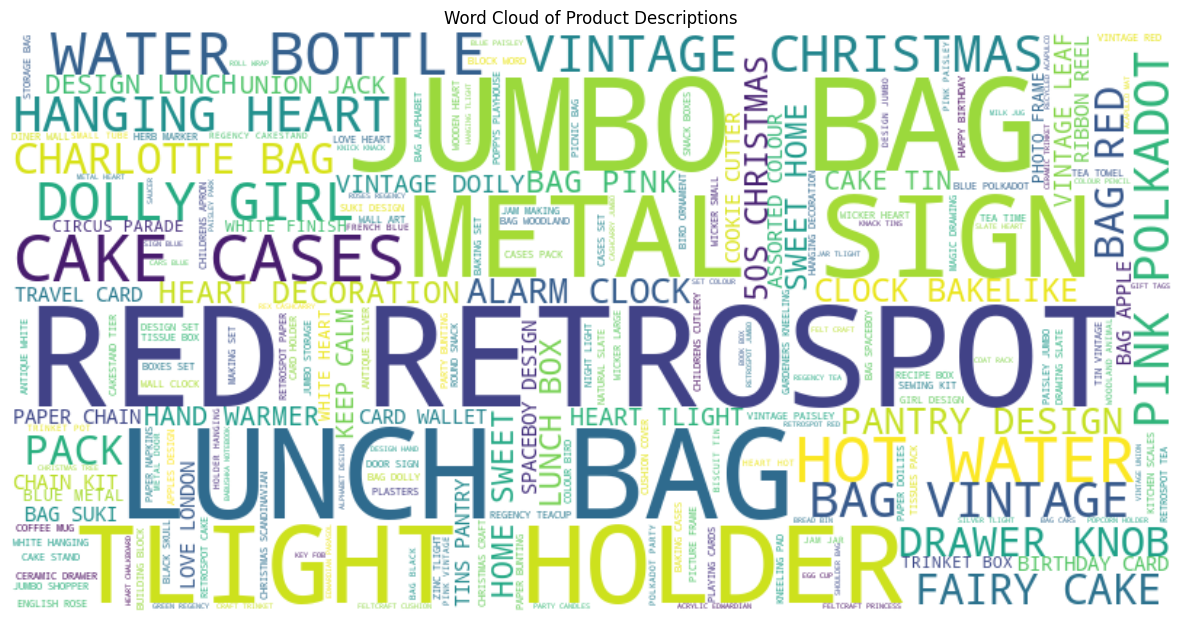

In [44]:
text = ' '.join(df['Description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Product Descriptions')
plt.show()

# **Phase-2**

##### 1) Hierarchical Clustering

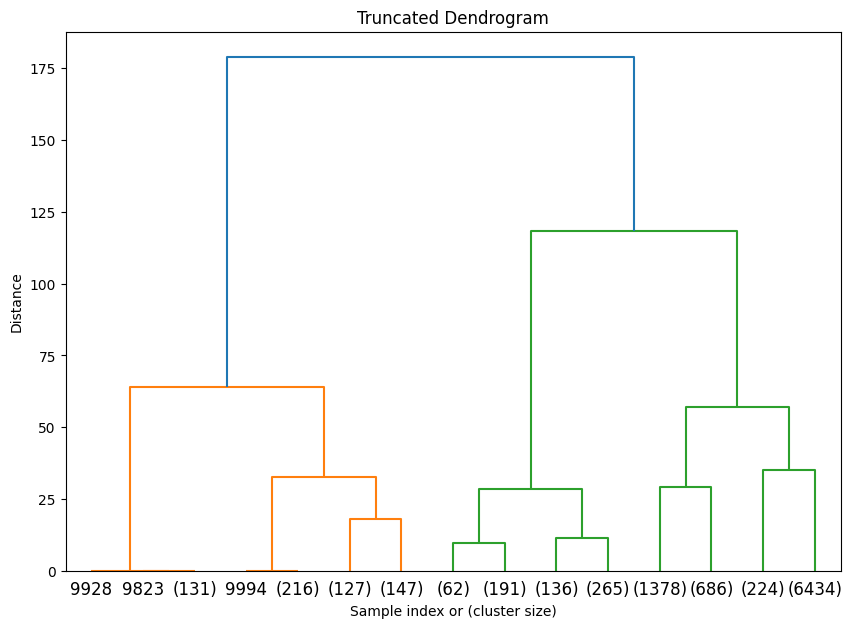

In [45]:
# Hierarchical clustering
sample_size = 10000 
df_sample = df.sample(n=sample_size, random_state=42)
features = ['Recency', 'Frequency', 'Monetary'] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sample[features])
linkage_matrix = hierarchy.linkage(scaled_features, method='ward')
def plot_dendrogram(linkage_matrix, **kwargs):
    plt.figure(figsize=(10, 7))
    hierarchy.dendrogram(linkage_matrix, **kwargs)
    plt.title('Truncated Dendrogram')
    plt.xlabel('Sample index or (cluster size)')
    plt.ylabel('Distance')
plot_dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.show()

**Justification**:
Hierarchical Structure

- Nested relationships between customer segments are revealed providing insights into the multi-level structure of retail data.
- The number of clusters does not need to be pre-specified, allowing for the identification of clusters in various shapes and sizes based on natural groupings.
- Dendrogram is produced, providing a visual representation of cluster formation that aids the interpretability.
- Consistent results are generated across runs, with every data point assigned to a cluster, ensuring a comprehensive analysis of the retail dataset

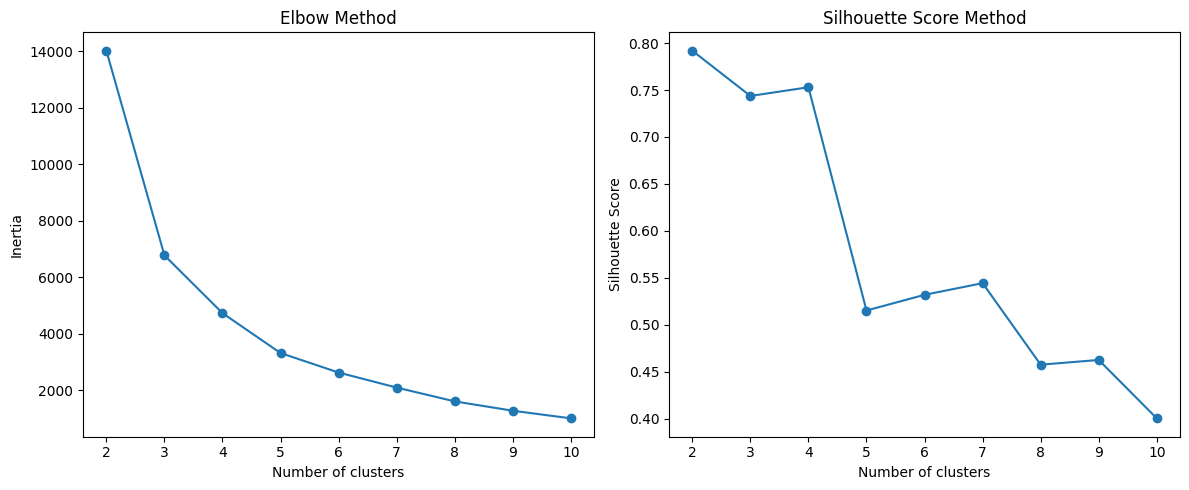

In [46]:
#Elbow and Silhouette Score method to find optimal number of clusters
max_clusters = 10
inertias = []
silhouette_scores = []
for n_clusters in range(2, max_clusters + 1):
    labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    cluster_centers = np.array([scaled_features[labels == i].mean(axis=0) for i in range(1, n_clusters+1)])
    inertia = sum(np.min(np.sum((scaled_features[:, np.newaxis] - cluster_centers) ** 2, axis=2), axis=1))
    inertias.append(inertia)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

The above image displays plots obtained by the Elbow Method and the Silhouette Score Method for determining the optimal number of clusters. These plots suggest that 3 or 4 clusters might be optimal, balancing cluster cohesion and separation effectively.

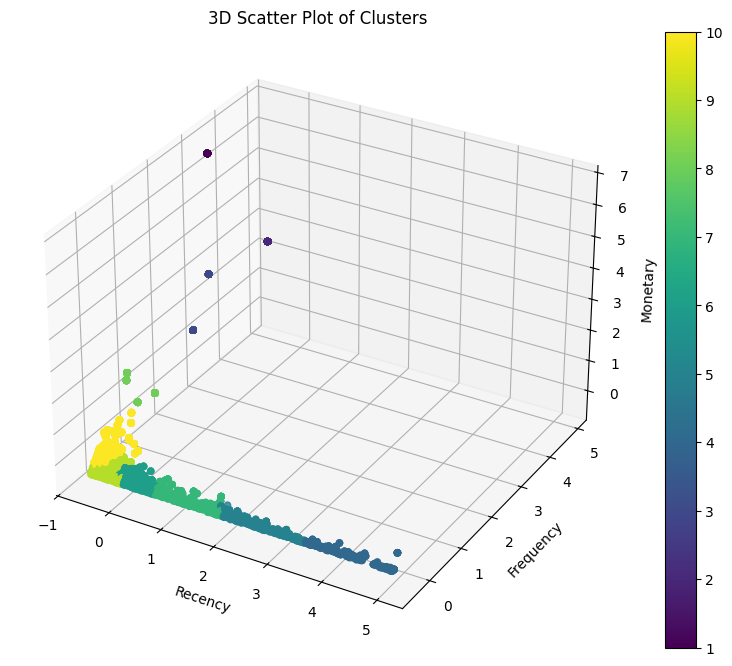

In [47]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(scaled_features[:, 0], scaled_features[:, 1], scaled_features[:, 2], c=labels, cmap='viridis')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title('3D Scatter Plot of Clusters')
plt.colorbar(scatter)
plt.show()

The above 3D scatter plot visually represents these clusters, showing the way data points are grouped based on recency, frequency, and monetary values.

##### 2) Agglomerative Clustering

Silhouette Score: 0.7529
Calinski-Harabasz Index: 16721.0505
Davies-Bouldin Index: 0.3474


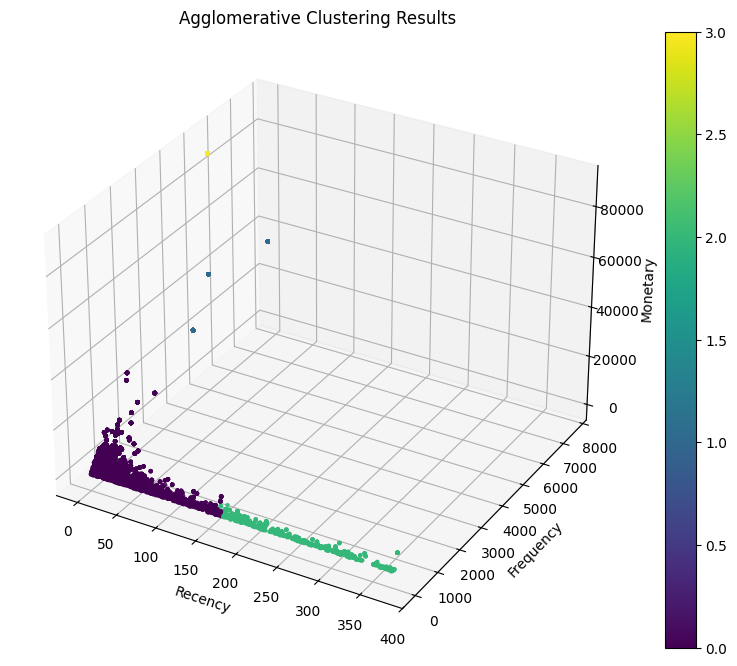

In [48]:
# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_sample['Agglomerative_Cluster'] = agglomerative.fit_predict(scaled_features)
# Evaluation metrics
silhouette = silhouette_score(scaled_features, df_sample['Agglomerative_Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_features, df_sample['Agglomerative_Cluster'])
davies_bouldin = davies_bouldin_score(scaled_features, df_sample['Agglomerative_Cluster'])
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_sample[features[0]], 
    df_sample[features[1]], 
    df_sample[features[2]], 
    c=df_sample['Agglomerative_Cluster'], 
    cmap='viridis', 
    s=5
)
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('Agglomerative Clustering Results')
plt.colorbar(scatter)
plt.show()

**Justification**: 
Agglomerative Clustering

- Distinct cluster identification is successfully done to identify four distinct clusters
- The clusters exhibit different shapes and densities handling varied cluster shapes
- The model effectively handled outliers, as seen in the sparse blue points at higher frequencies, without letting them significantly impact the main cluster formations
- The visualization shows both well-separated clusters and areas of potential overlap demonstrating the algorithm's ability to handle complex data relationships

##### 3) Birch Clustering

Silhouette Score: 0.7543
Calinski-Harabasz Index: 14878.0238
Davies-Bouldin Index: 0.3314


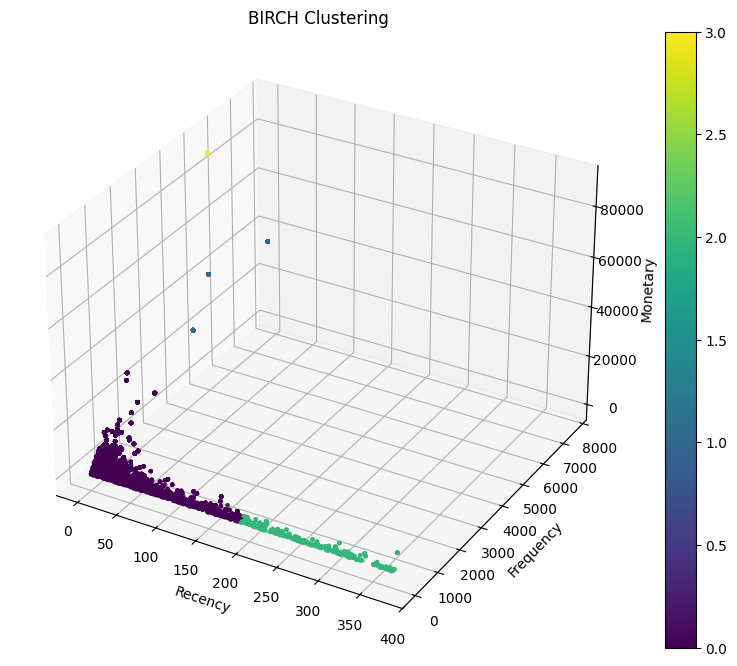

In [49]:
features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sample[features])
birch = Birch(n_clusters=4, threshold=0.5, branching_factor=50)
df_sample['BIRCH_Cluster'] = birch.fit_predict(scaled_features)
silhouette = silhouette_score(scaled_features, df_sample['BIRCH_Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_features, df_sample['BIRCH_Cluster'])
davies_bouldin = davies_bouldin_score(scaled_features, df_sample['BIRCH_Cluster'])
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_sample[features[0]], 
    df_sample[features[1]], 
    df_sample[features[2]], 
    c=df_sample['BIRCH_Cluster'], 
    cmap='viridis', 
    s=5
)
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('BIRCH Clustering')
plt.colorbar(scatter)
plt.show()

**Justification**: 
Birch Clustering

- The data points are clearly separated into distinct groups, as indicated by different colors.
- The clusters are well-defined along the axes of recency and frequency.
- High silhouette score and low Davies-Bouldin index confirm the visual separation, supporting BIRCH's effectiveness in clustering this dataset.
- Handling of outliers and very large datasets, makes it ideal.

##### 4) K-Means Clustering

Silhouette Score: 0.7271
Calinski-Harabasz Index: 13966.6193
Davies-Bouldin Index: 0.6573


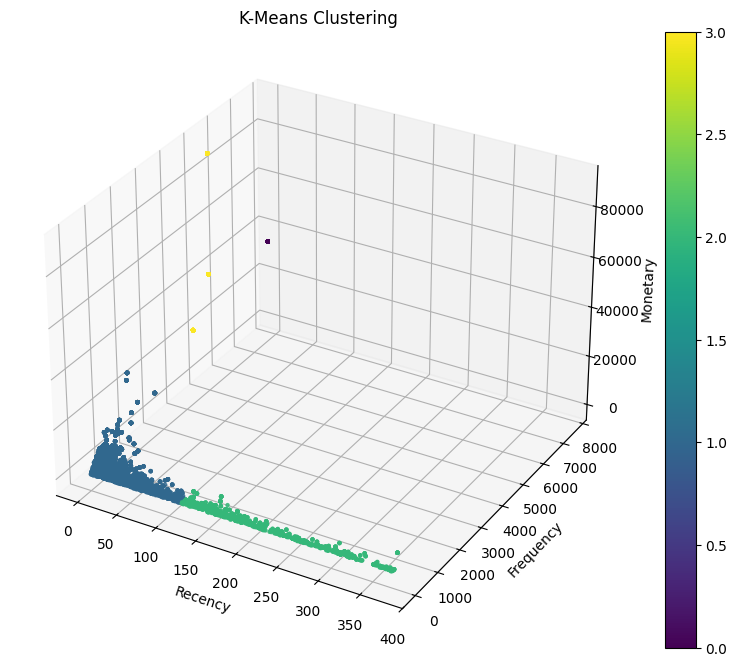

In [50]:
#K-Means Clustering
features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sample[features])
kmeans = KMeans(n_clusters=4, random_state=42)
df_sample['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)
# Evaluation metrics
silhouette = silhouette_score(scaled_features, df_sample['KMeans_Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_features, df_sample['KMeans_Cluster'])
davies_bouldin = davies_bouldin_score(scaled_features, df_sample['KMeans_Cluster'])
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_sample[features[0]], 
    df_sample[features[1]], 
    df_sample[features[2]], 
    c=df_sample['KMeans_Cluster'], 
    cmap='viridis', 
    s=5
)
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('K-Means Clustering')
plt.colorbar(scatter)
plt.show()

**Justification**: 
  K-Means:
- Efficiency with large datasets is achieved, crucial for handling extensive transaction data.
- Customer segmentation based on purchasing behavior is enabled, grouping similar buying patterns.
- Distinct product categories based on sales patterns can be identified by the implementation of K-Means Clustering.
- Ease of Ease of interpretation is provided, facilitating actionable business insights.

##### 5) Linear Regression

Mean Squared Error: 47440201.072142005
R-squared Score: 0.6816545024340144


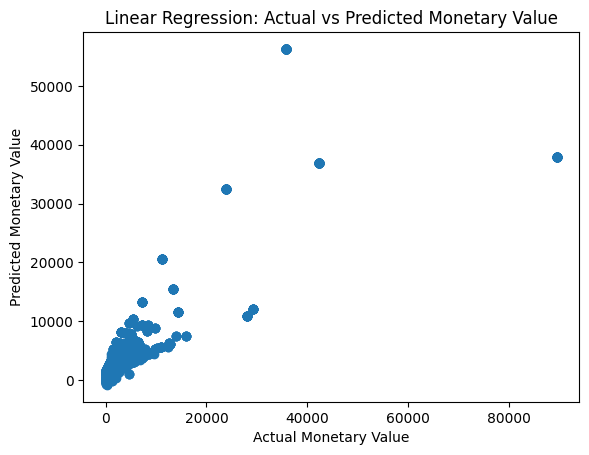

In [51]:
# Linear Regression
X = df_sample[['Recency', 'Frequency']]
y = df_sample['Monetary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Monetary Value")
plt.ylabel("Predicted Monetary Value")
plt.title("Linear Regression: Actual vs Predicted Monetary Value")
plt.show()

*Justification:*
Linear Regression
- High Mean Square Error indicates poor predictive performance for Linear Regression.
- The R-Squared score suggests that the model explains 68% of the variance in the data.
- Despite having high MSE the model can still provide valuable insights into general trends and relationships in the data. 
- This is useful for for achieving goals related to customer segmentation and understanding purchasing behaviors.
- The high MSE also justifies the approach of using multiple algorithms to gain a comprehensive understanding of customer behavior.

##### 6) Knn Classifier

Accuracy: 0.9523333333333334
                      precision    recall  f1-score   support

      Best Customers       0.96      0.97      0.96      1537
Lost Cheap Customers       0.85      0.65      0.74        26
      Lost Customers       0.83      0.81      0.82        42
     Loyal Customers       0.76      0.65      0.70        49
               Other       0.95      0.96      0.95      1346

            accuracy                           0.95      3000
           macro avg       0.87      0.81      0.84      3000
        weighted avg       0.95      0.95      0.95      3000



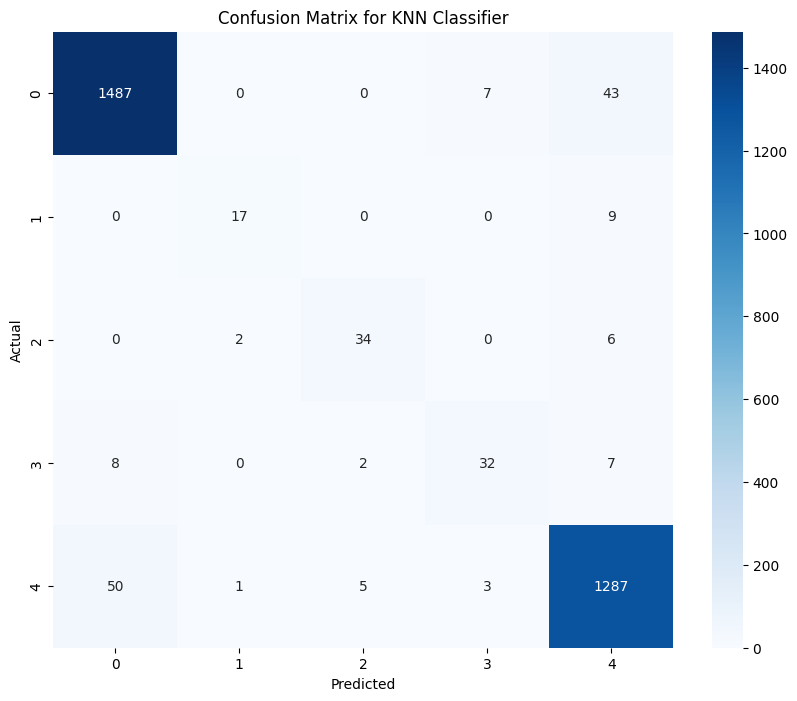

In [52]:
# KNN classifier
X = df_sample[['Recency', 'Frequency', 'Monetary']]
y = df_sample['RFM_Segment'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

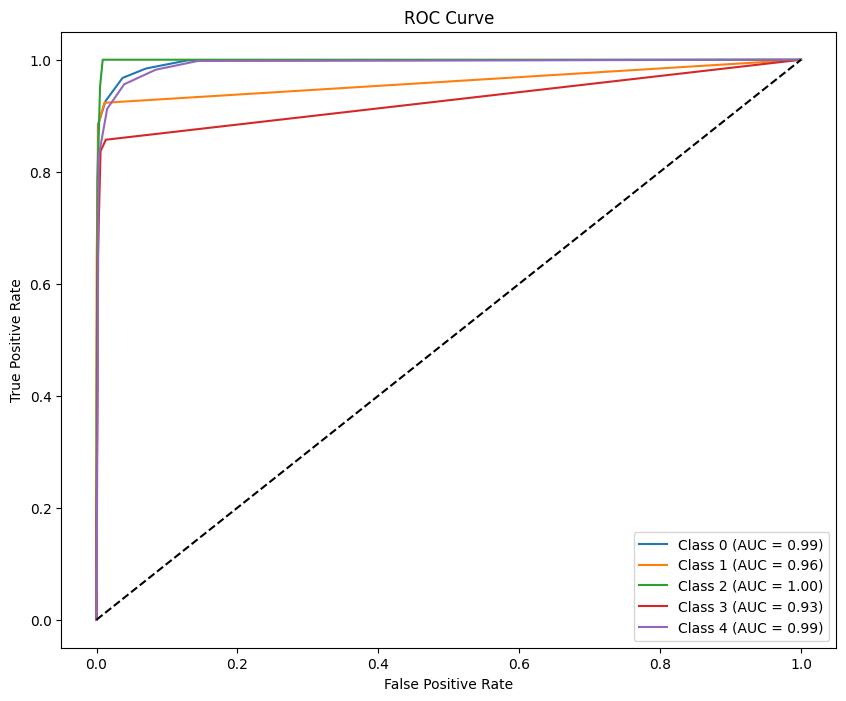

In [53]:
# KNN Classifier: ROC Curve
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_prob = knn.predict_proba(X_test)
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

*Justification:*
KNN classifier
- KNN model is good choice for your customer clustering project, achieving 95.23% accuracy in classifying segments based on RFM characteristics. 
- High AUC values in the ROC curve indicate that KNN excels at distinguishing between different customer classes..
- Identification of local patterns in customer behavior, enabling nuanced segmentation that supports targeted marketing strategies can be done effectively using KNN.
- Customer retention and diverse purchasing behaviors are supported by the implementation of KNN, making it a valuable asset for clustering the customers. 

##### 7) Logistic Regression

Accuracy: 0.9407933032125732
Confusion Matrix:
[[17670     0     0     0   321]
 [    0     0     0     0   364]
 [  269     0    48     0   117]
 [  488     0     0     0    94]
 [  482     0     1     0 16223]]

Classification Report:
                      precision    recall  f1-score   support

      Best Customers       0.93      0.98      0.96     17991
Lost Cheap Customers       0.00      0.00      0.00       364
      Lost Customers       0.98      0.11      0.20       434
     Loyal Customers       0.00      0.00      0.00       582
               Other       0.95      0.97      0.96     16706

            accuracy                           0.94     36077
           macro avg       0.57      0.41      0.42     36077
        weighted avg       0.92      0.94      0.92     36077



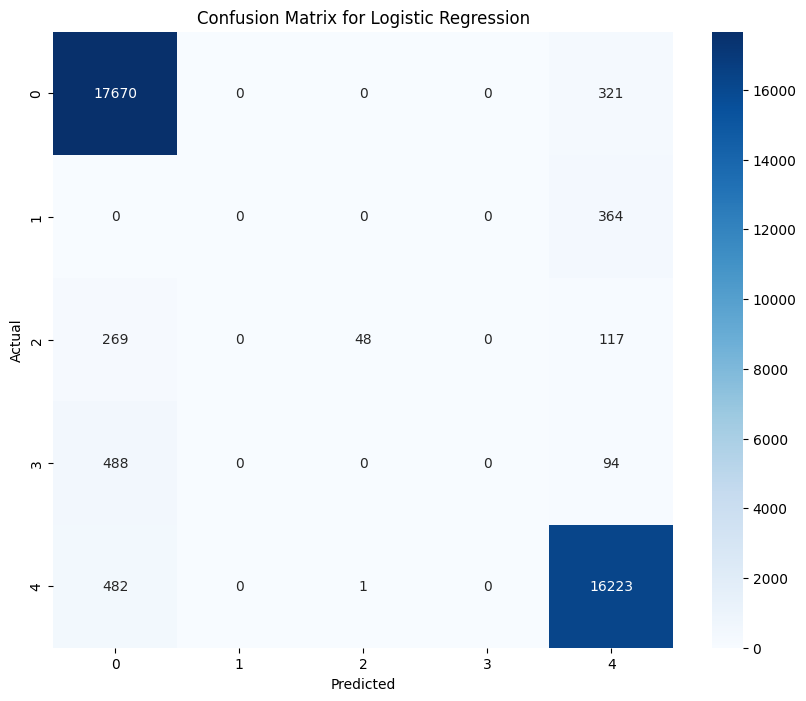

In [54]:
#Logistic Regression
features = ['Recency', 'Frequency', 'Monetary', 'Total_Price', 'Quantity']
X = df[features]
y = df['RFM_Segment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr_model = LogisticRegression(multi_class='ovr', random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

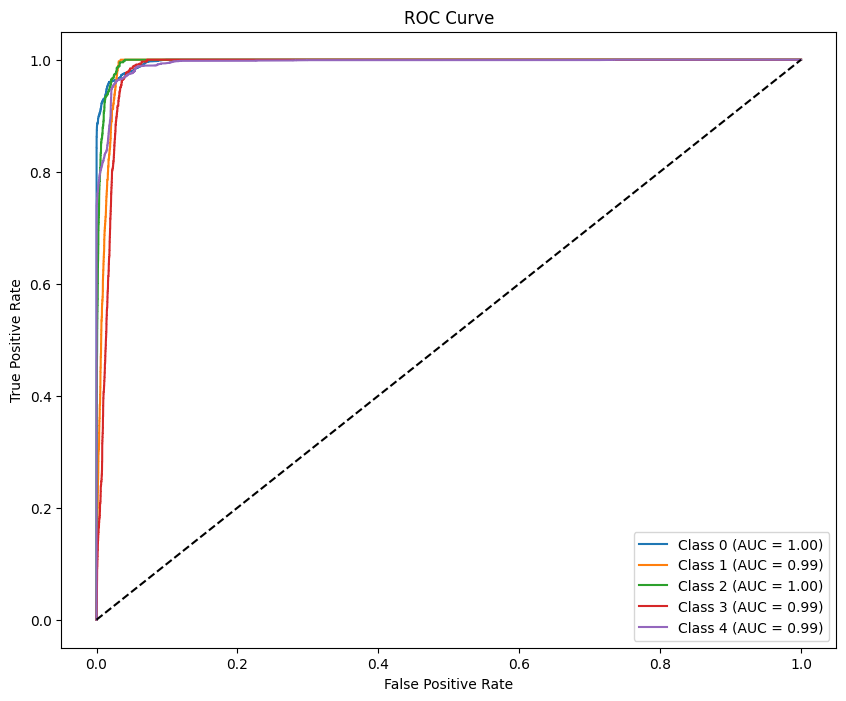

In [55]:
# Logistic Regression: ROC Curve
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_prob = lr_model.predict_proba(X_test_scaled)
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

*Justification:*
Logistic Regression
- The logistic regression model is not suitable for this customer clustering project despite its high overall accuracy.
- It fails to identify crucial customer segments hindering the goals of the project in developing targeted marketing strategies to improve customer retention.
- The performance of the model is skewed by class imbalance, making it ineffective for the nuanced customer segmentation required.
- A model capable of handling multiclass problems and imbalanced data would be better suited for achieving the better results.